In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

In [2]:
from datautils import *
# from sphUtils import *
from lossFunctions import *

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
training, validation, counter = getSamples(1024, maxRollOut = 8, chunked = True, trainValidationSplit = 0.8, limitRollOut = False)

In [5]:

# trainingSample = training[np.random.permutation(np.arange(training.shape[0]))]
trainingSample = training
trainingCounter = counter[trainingSample]
validationSample = copy.copy(validation)
validationCounter = counter[validationSample]
# print(trainingSample, trainingCounter)
# print(validationSample, validationCounter)

In [6]:
# fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

# axis[0,0].imshow(counter[None,:], aspect='auto', interpolation='nearest')

In [7]:
# basePath = '~/servus03/dev/rbfConvolution/output_smaller_arch'
basePath = '../export'
# basePath = '~/servus03/dev/rbfConvolution/outputs/output_smaller_arch'
basePath = os.path.expanduser(basePath)

In [8]:
simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
for i, c in enumerate(simulationFiles):
    print(i ,c)

0 ../export/dambreak - 2023-02-09_13-21-08.hdf5
1 ../export/dambreak - 2023-02-09_09-54-16.hdf5


In [9]:
# simulationFiles = [simulationFiles[0]]

In [10]:
inFile = h5py.File(simulationFiles[0], 'r')
frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
inFile.close()

In [11]:
debugPrint(frameCount)

frameCount [int] = 1999


In [12]:
# def splitFile(s, skip = 32, cutoff = 300, chunked = True, maxRollOut = 8, split = True, trainValidationSplit = 0.8, testSplit = 0.1, limitRollOut = False):
#     inFile = h5py.File(s, 'r')
#     frameCount = int(len(inFile.keys()) -1) # adjust for bptcls
#     inFile.close()
    
#     frameCount = min(cutoff, frameCount)
#     actualCount = frameCount - 1 - skip
    
#     if not split:
#         training, _, counter = getSamples(actualCount, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = 1.)
#         return s, training + skip, counter
    
#     testIndex = frameCount - 1 - int(actualCount * testSplit)
#     testSamples = frameCount - 1 - testIndex
    
#     testingIndices, _, testingCounter = getSamples(testSamples, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = 1.)
#     testingIndices = testingIndices + testIndex
    
#     trainingIndices, validationIndices, trainValidationCounter = getSamples(testIndex - skip, maxRollOut = maxRollOut, chunked = chunked, trainValidationSplit = trainValidationSplit, limitRollOut = limitRollOut)
#     trainingCounter = trainValidationCounter[trainingIndices]
#     validationCounter = -trainValidationCounter[validationIndices]
    
#     trainingIndices = trainingIndices + skip
#     validationIndices = validationIndices + skip
    
    
#     return s, (trainingIndices, trainingCounter), (validationIndices, validationCounter), (testingIndices, testingCounter)
    
    
training = []
validation = []
testing = []


for s in simulationFiles:    
    _, train, valid, test = splitFile(s, split = True, limitRollOut = False, skip = 0, cutoff = 10)
    training.append((s,train))
    validation.append((s,valid))
    testing.append((s,test))

In [13]:
# debugPrint(training)

In [14]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader


class datasetLoader(Dataset):
    def __init__(self, data):
        self.frameCounts = [indices[0].shape[0] for s, indices in data]
        self.fileNames = [s for s, indices in data]
        
        self.indices = [indices[0] for s, indices in data]
        self.counters = [indices[1] for s, indices in data]
        
#         print(frameCounts)
        
        
    def __len__(self):
#         print('len', np.sum(self.frameCounts))
        return np.sum(self.frameCounts)
    
    def __getitem__(self, idx):
#         print(idx , ' / ', np.sum(self.frameCounts))
        cs = np.cumsum(self.frameCounts)
        p = 0
        for i in range(cs.shape[0]):
#             print(p, idx, cs[i])
            if idx < cs[i] and idx >= p:
#                 print('Found index ', idx, 'in dataset ', i)
#                 print('Loading frame ', self.indices[i][idx - p], ' from dataset ', i, ' for ', idx, p)
                return self.fileNames[i], self.indices[i][idx - p], self.counters[i][idx-p]
        

                return (i, self.indices[i][idx - p]), (i, self.indices[i][idx-p])
#                 return torch.rand(10,1), 2
            p = cs[i]
        return None, None


In [15]:
# simFile = simulationFiles[0]
# inFile = h5py.File(simFile)

In [16]:
# grp = inFile['simulationExport']['%05d' % 1]
# debugPrint(inFile.keys())

In [17]:

# inFile = h5py.File(simulationFiles[0])
# inGrp = inFile['simulationExport']['%05d' % 0]

In [18]:
# inGrp.attrs.keys()

In [19]:
def loadFrame(filename, frame, frameOffsets = [1], frameDistance = 1):
    inFile = h5py.File(filename)
    inGrp = inFile['simulationExport']['%05d' % frame]

    attributes = {
     'support': np.max(inGrp['fluidSupport'][:]),
     'targetNeighbors': inFile.attrs['targetNeighbors'],
     'restDensity': inFile.attrs['restDensity'],
     'dt': inGrp.attrs['dt'],
     'time': inGrp.attrs['time']
    }
#     debugPrint(inGrp.attrs['timestep'])

    support = inFile.attrs['restDensity']
    targetNeighbors = inFile.attrs['targetNeighbors']
    restDensity = inFile.attrs['restDensity']
    dt = inFile.attrs['initialDt']

    inputData = {
        'fluidPosition': torch.from_numpy(inGrp['fluidPosition'][:]).type(torch.float32),
        'fluidVelocity': torch.from_numpy(inGrp['fluidVelocity'][:]).type(torch.float32),
        'fluidArea' : torch.from_numpy(inGrp['fluidArea'][:]).type(torch.float32),
        'fluidDensity' : torch.from_numpy(inGrp['fluidDensity'][:]).type(torch.float32),
        'fluidSupport' : torch.from_numpy(inGrp['fluidSupport'][:]).type(torch.float32),
        'fluidGravity' : torch.from_numpy(inGrp['fluidGravity'][:]).type(torch.float32) if 'fluidGravity' not in inFile.attrs else torch.from_numpy(inFile.attrs['fluidGravity']).type(torch.float32) * torch.ones(inGrp['fluidDensity'][:].shape[0])[:,None],
        'boundaryPosition': torch.from_numpy(inFile['boundaryInformation']['boundaryPosition'][:]).type(torch.float32),
        'boundaryNormal': torch.from_numpy(inFile['boundaryInformation']['boundaryNormals'][:]).type(torch.float32),
        'boundaryVelocity': torch.from_numpy(inFile['boundaryInformation']['boundaryVelocity'][:]).type(torch.float32)
    }
    
    groundTruthData = []
    for i in frameOffsets:
        gtGrp = inFile['simulationExport']['%05d' % (frame + i * frameDistance)]
#         debugPrint((frame + i * frameDistance))
#         debugPrint(gtGrp.attrs['timestep'])
        gtData = {
            'fluidPosition'    : torch.from_numpy(gtGrp['fluidPosition'][:]),
            'fluidVelocity'    : torch.from_numpy(gtGrp['fluidVelocity'][:]),
            'fluidDensity'     : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'fluidPressure'    : torch.from_numpy(gtGrp['fluidPressure'][:]),
    #         'boundaryDensity'  : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'boundaryPressure' : torch.from_numpy(gtGrp['fluidPressure'][:]),
        }
        
        groundTruthData.append(torch.hstack((gtData['fluidPosition'].type(torch.float32), gtData['fluidVelocity'], gtData['fluidDensity'][:,None])))
        
    
    inFile.close()
    
    return attributes, inputData, groundTruthData

In [20]:
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1))
debugPrint(inputData['fluidPosition'].shape)
debugPrint(groundTruthData[0][:,-1:].shape)

inputData['fluidPosition'].shape [Size] = torch.Size([762, 2])
groundTruthData[0][:,-1:].shape [Size] = torch.Size([762, 1])


In [21]:
# debugPrint(features)
# debugPrint(gt)

In [22]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

In [23]:
seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

In [24]:
from joblib import Parallel, delayed

In [25]:
from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

In [26]:
n = 8
rbf_x = rbf_y = 'rbf gaussian'
forwardBatch = backwardBatch = 1024

windowFn = lambda r: torch.clamp(1-r**2, min = 0)
# windowFn = None

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu'):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = False, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        
        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = n,
                rbf = [rbf_x, rbf_y], periodic = False,
                dense_for_center = denseLayer, bias = False, activation = 'relu',
                batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = 2,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=2,bias=False))


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
#         debugPrint(torch.max(boundaryEdgeLengths))
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         debugPrint(boundaryEdgeIndex.shape)        
#         debugPrint(boundaryEdgeLengths.shape)
        
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         debugPrint(fluidEdgeIndex.shape)        
#         debugPrint(fluidEdgeLengths.shape)
#         debugPrint(fluidFeatures.shape)
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
#         debugPrint(linearOutput)
#         debugPrint(linearOutput.shape)
#         debugPrint(boundaryFeatures)
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(boundaryConvolution)
#         debugPrint(torch.max(boundaryConvolution))
#         debugPrint(boundaryConvolution.shape)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution)
#         debugPrint(fluidConvolution.shape)
        ans = torch.hstack((boundaryConvolution, fluidConvolution, boundaryConvolution))
#         debugPrint(ans.shape)
#         debugPrint(layer0out.shape)
#         return self.fcs[1](layer0out)
        
    
        layers = len(self.convs)
        for i in range(2,layers):
#             debugPrint(ans.shape)
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.relu(self.fcs[i - 1](ans)) if i != layers - 1 else  self.fcs[i - 1](ans)
            
#             debugPrint(ansConv.shape)
#             debugPrint(ansDense.shape)
#             debugPrint(self.features[i-2])
#             debugPrint(self.features[i-1])
            if self.features[i-2] == self.features[i-1]:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
        return ans
            

In [27]:
n = 8
rbf_x = rbf_y = 'linear'
forwardBatch = backwardBatch = 1

windowFn = lambda r: torch.clamp(1-r**2, min = 0)
# windowFn = None

class DensityNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu'):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = 1,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = 1,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = False, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        

    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
            
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = (fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
#         debugPrint(torch.min(fluidEdgeLengths))
#         debugPrint(torch.max(fluidEdgeLengths))
        
#         boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
        return fluidConvolution
        return fluidConvolution + boundaryConvolution

In [28]:
def constructFluidFeatures(inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 inputData['fluidGravity'].type(torch.float32)))

    fluidFeatures = torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)
#     debugPrint(inputData)
#     boundaryFeatures = torch.hstack()
    boundaryFeatures = inputData['boundaryNormal'].type(torch.float32)
    
    return inputData['fluidPosition'].type(torch.float32), inputData['boundaryPosition'].type(torch.float32), fluidFeatures, boundaryFeatures

In [29]:
# debugPrint(training[0][1][0][0])

In [30]:
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], training[0][1][0][0], 1 + np.arange(1))


In [31]:
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)

In [44]:
nx = 2
ny = 4
fin = 6
fout = 8

ni = 128
nj = 64

support = 0.125

positions_i = torch.rand((ni,2)).type(torch.float64)#fluidPositions[:128,:]
positions_j = torch.rand((nj,2)).type(torch.float64)#fluidPositions[:64,:]

fluidFeatures_i = torch.rand((positions_i.shape[0], fin)).type(torch.float64)
fluidFeatures_j = torch.rand((positions_j.shape[0], fin)).type(torch.float64)
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

fi, fj = radius(positions_j, positions_i, support, max_num_neighbors = 256, batch_x = None, batch_y = None)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = (positions_j[fluidEdgeIndex[1]] - positions_i[fluidEdgeIndex[0]])/support

weight = Parameter(torch.Tensor(nx,ny, fin, fout))
torch.nn.init.xavier_normal_(weight);
# with torch.no_grad():
#     weight[:,:,:,:] = 1

# debugPrint(fluidFeatures)
#         debugPrint(torch.min(fluidEdgeLengths))

convolution = cutlass.apply

# out = convolution(fluidEdgeIndex, fluidFeatures, fluidEdgeLengths, None, weight, 
#                                             fluidFeatures.shape[0], 0,
#                                         [nx, ny] , ['linear', 'linear'], [False, False], 
#                                         1,1)

# debugPrint(out)




# globalNumerical, globalAnalytical = None, None

# gradcheck(convOp, weight.type(torch.float64))


In [46]:
# debugPrint(fi.shape)

In [47]:
from gradcheck import *

In [48]:
weight.requires_grad = False
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

In [49]:
convOp = lambda x: convolution(fluidEdgeIndex, fluidFeatures_i, x, fluidEdgeLengths.type(torch.float64), None, weight.type(torch.float64), 
                                            fluidFeatures_i.shape[0], 0,
                                        [nx, ny] , ['linear', 'linear'], [False, False], 
                                        1,1)

debugPrint(torch.max(fluidEdgeIndex[0]))
debugPrint(torch.max(fluidEdgeIndex[1]))

result = convOp(fluidFeatures_j.type(torch.float64))
# debugPrint(result)
debugPrint(result.dtype)
debugPrint(result.shape)

weight.requires_grad = False
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, fluidFeatures_j.type(torch.float64)))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, fluidFeatures_j.type(torch.float64)))

torch.max(fluidEdgeIndex[0]) [Tensor] = 127
torch.max(fluidEdgeIndex[1]) [Tensor] = 63
result.dtype [dtype] = torch.float64
result.shape [Size] = torch.Size([128, 8])
gradcheck(convOp, fluidFeatures_j.type(torch.float64)) [bool] = True
gradcheck(convOp, fluidFeatures_j.type(torch.float64)) [bool] = True


In [50]:

convOp = lambda x: convolution(fluidEdgeIndex, fluidFeatures_i.type(torch.float64), fluidFeatures_j, fluidEdgeLengths.type(torch.float64), None, x, 
                                            fluidFeatures_i.shape[0], 0,
                                        [nx, ny] , ['linear', 'linear'], [False, False], 
                                        1,1)

gradcheck(convOp, weight.type(torch.float64))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

debugPrint(gradcheck(convOp, weight.type(torch.float64)))

weight.requires_grad = True
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = True

debugPrint(gradcheck(convOp, weight.type(torch.float64)))

gradcheck(convOp, weight.type(torch.float64)) [bool] = True
gradcheck(convOp, weight.type(torch.float64)) [bool] = True


In [45]:

from gradcheck import globalNumerical, globalAnalytical

<IPython.core.display.Javascript object>


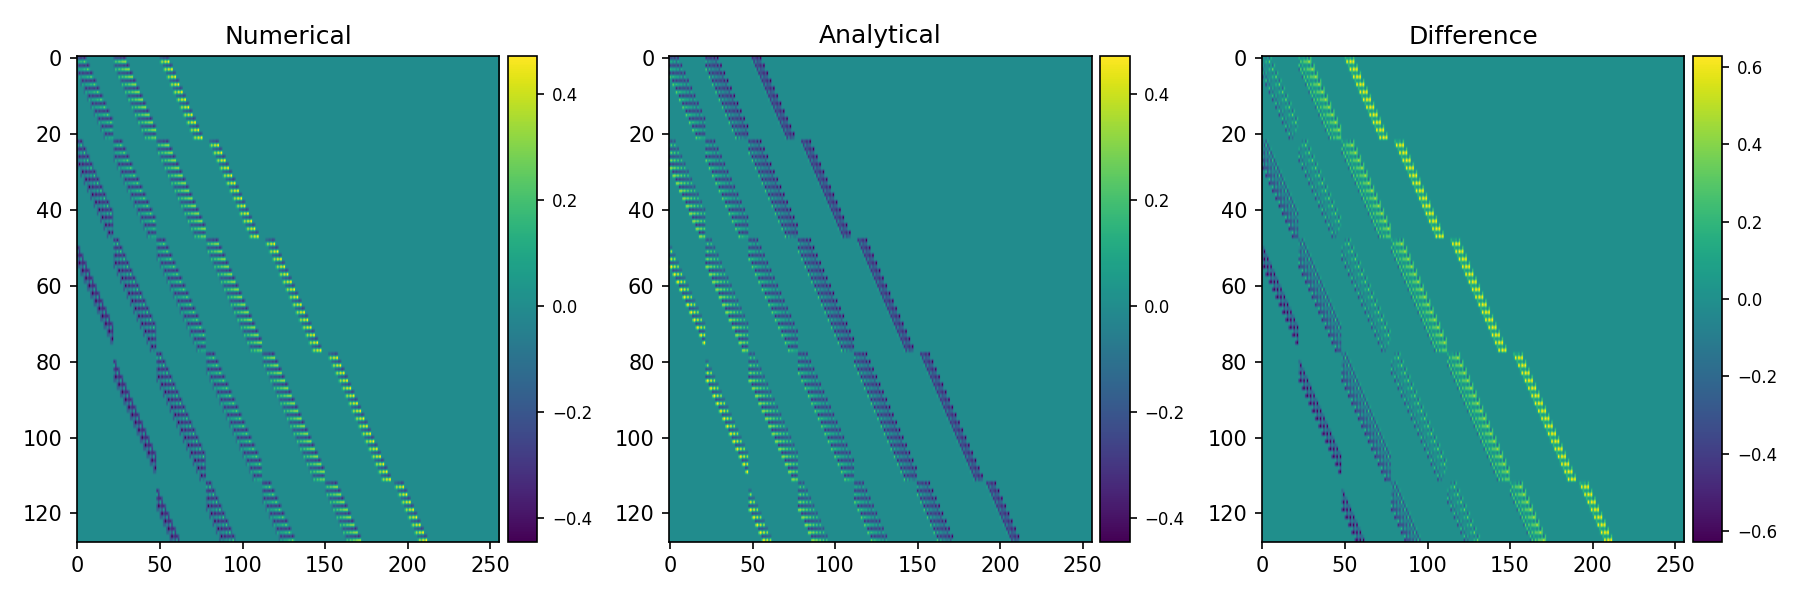

In [46]:
# This is only possible if there was an error
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Numerical')
im = axis[0,0].imshow(globalNumerical)
ax1_divider = make_axes_locatable(axis[0,0])
axis[0,0].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('Analytical')
im = axis[0,1].imshow(globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,1])
axis[0,1].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Difference')
im = axis[0,2].imshow(globalNumerical - globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,2])
axis[0,2].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


In [32]:
# debugPrint(fluidPositions.shape)
# debugPrint(boundaryPositions.shape)
# debugPrint(fluidFeatures.shape)
# debugPrint(boundaryFeatures.shape)

In [33]:
debugPrint(fluidPositions.shape)
debugPrint(boundaryPositions.shape)
debugPrint(fluidFeatures.shape)
debugPrint(boundaryFeatures.shape)

fluidPositions.shape [Size] = torch.Size([762, 2])
boundaryPositions.shape [Size] = torch.Size([367, 2])
fluidFeatures.shape [Size] = torch.Size([762, 1])
boundaryFeatures.shape [Size] = torch.Size([367, 2])


In [34]:
boundaryFeatures = torch.rand(boundaryFeatures.shape).to(device)

In [35]:
model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])
model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

prediction = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

AttributeError: 'tuple' object has no attribute 'to'

In [ ]:
debugPrint(prediction.shape)

In [ ]:
# attrs, inputData, features, gt = loadFrame(simulationFiles[0],50, np.arange(1))
# # positions, features = prepareInput(inputData)
# # debugPrint(features)
# positions = inputData['fluidPosition'].to(device)
# difference = positions
# distance = torch.linalg.norm(difference,axis=1)
# difference[distance > 1e-7] = difference[distance > 1e-7] / distance[distance > 1e-7, None]
# gravity = -1 * difference * (distance)[:,None]
# features = torch.hstack((torch.ones(features.shape[0]).type(torch.float32).to(device).unsqueeze(dim=1), features.to(device), gravity.to(device)))


inputFeatures = fluidFeatures.shape[1]

# del features, attrs, features, gt

In [ ]:
widths = [8,8, 2]

layerDescription ='Layers:'

for i, w in enumerate(widths):
    win = inputFeatures if i == 0 else widths[i-1] + inputFeatures
    wout = 2 if i == len(widths) - 1 else widths[i]
    relu = 'placeholder' if i == len(widths) -1 else 'activation'
    layerDescription = layerDescription + f'''
    - inFeatures: {win}
      outFeatures: {wout}
      dimension: 2
      bias: False
      centerLayer: True
      periodic: False 
      {relu}: relu    '''
    
layerDescription = yaml.load(layerDescription, Loader = yaml.Loader)

In [ ]:

# fig, axis = plt.subplots(1, 1, figsize=(9,4), sharex = False, sharey = False, squeeze = False)

# axis[0,0].set_title('input')
# x = fluidPositions[:,0].detach().cpu().numpy()
# y = fluidPositions[:,1].detach().cpu().numpy()
# v = torch.linalg.norm(inputData['fluidVelocity'],axis=1).detach().cpu().numpy()
# # sc = axis[0,0].tripcolor(x,y,v)
# sc = axis[0,0].scatter(x,y,c = v , s = 2)
# sc = axis[0,0].scatter(boundaryPositions[:,0].detach().cpu().numpy(),boundaryPositions[:,1].detach().cpu().numpy(),c = 'blue' , s = 2)
# axis[0,0].axis('equal')
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 
# fig.tight_layout()


In [ ]:


numerical, analytical = None, None

GradcheckError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[-1.2156, -0.9730, -0.7305,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9730, -1.2156, -0.9730,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7305, -0.9730, -1.2156,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -1.2156, -0.9730, -0.7305],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.9730, -1.2156, -0.9730],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.7305, -0.9730, -1.2156]],
       dtype=torch.float64)
analytical:tensor([[ -7.9349,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,  -9.4927,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000, -10.2232,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ..., -10.2232,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -9.4927,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  -7.9349]],
       dtype=torch.float64)


In [56]:
debugPrint(globalNumerical)

globalNumerical [Tensor] = tensor([[-1.2156, -0.9730, -0.7305,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9730, -1.2156, -0.9730,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7305, -0.9730, -1.2156,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -1.2156, -0.9730, -0.7305],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.9730, -1.2156, -0.9730],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.7305, -0.9730, -1.2156]],
       dtype=torch.float64)


<IPython.core.display.Javascript object>


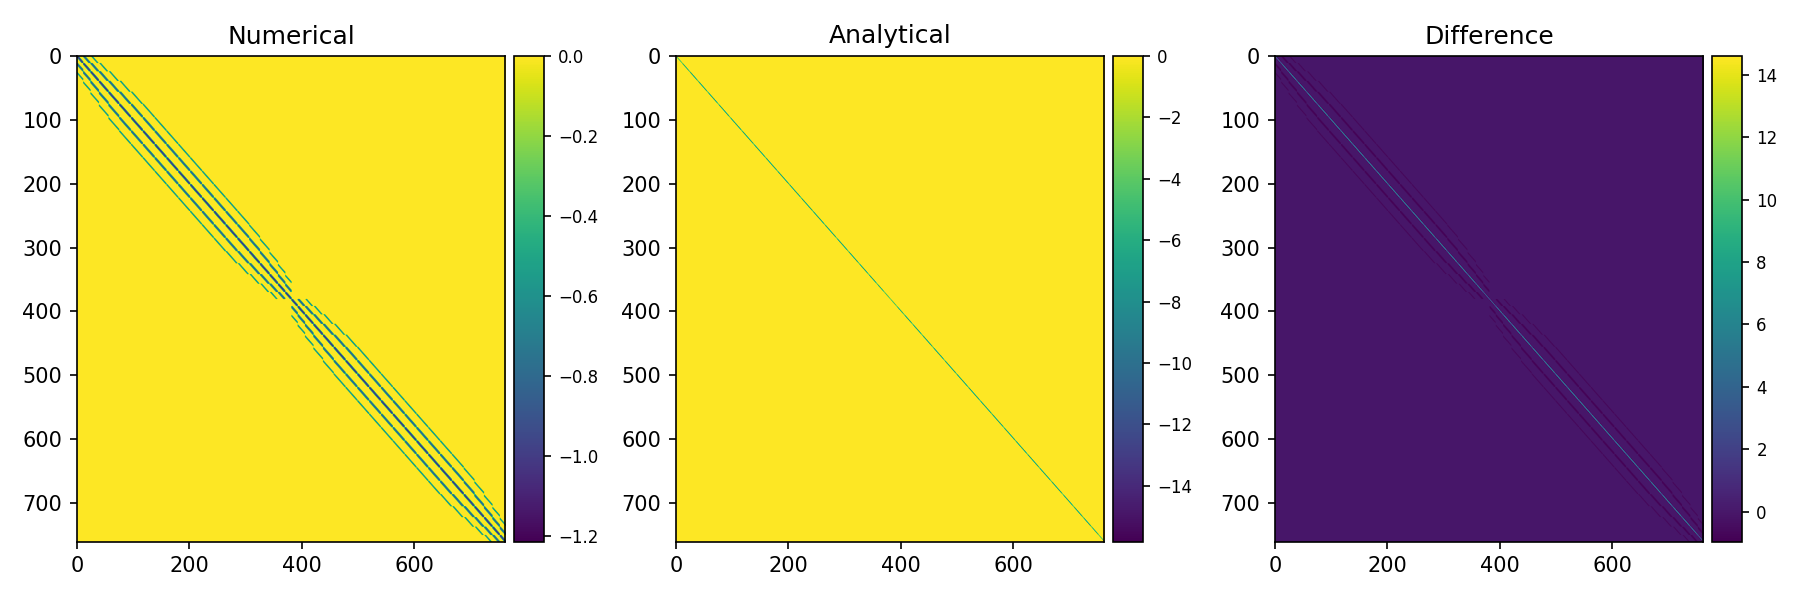

In [99]:
debugPrint(fluidFeatures.shape)
# model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])
model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))


optimizer.zero_grad()

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = 8).batch_sampler

# epoch = 
maxRollOut = 10
model.train()

lossFn = 'v'
shiftSteps = 2
epochs = 25


fluidFeatures.shape [Size] = torch.Size([762, 1])
Number of parameters 193


In [100]:
#  semi implicit euler, network predicts velocity update
def integrateState(inputPositions, inputVelocities, modelOutput, dt):
    predictedVelocity = modelOutput #inputVelocities +  modelOutput 
    predictedPosition = inputPositions + attributes['dt'] * predictedVelocity
    
    return predictedPosition, predictedVelocity
# velocity loss
def computeLoss(predictedPosition, predictedVelocity, groundTruth):
    return torch.linalg.norm(groundTruth[:,2:] - predictedVelocity, dim = 1)

def loadData(dataset, index, unroll = 1):
    fileName, frameIndex, maxRollouts = train_ds[index]

    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(unroll))
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
    
    return attributes, fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, groundTruthData


def loadBatch(bdata, unroll = 1):
    fluidPositions = []
    boundaryPositions = []
    fluidFeatures = []
    boundaryFeatures = []
    fluidBatchIndices = []
    boundaryBatchIndices = []
    groundTruths = []
    for i in range(unroll):
        groundTruths.append([])
    
    for i,b in enumerate(bdata):
#         debugPrint(i)
#         debugPrint(b)
        attribute, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, groundTruth = loadData(train_ds, b, unroll = unroll)     
#         debugPrint(groundTruth)
        fluidPositions.append(fluidPosition)
#         debugPrint(fluidPositions)
        boundaryPositions.append(boundaryPosition)
        fluidFeatures.append(fluidFeature)
        boundaryFeatures.append(boundaryFeature)
        
        batchIndex = torch.ones(fluidPosition.shape[0], device = device) * i
        fluidBatchIndices.append(batchIndex)
        
        batchIndex = torch.ones(boundaryPosition.shape[0], device = device) * i
        boundaryBatchIndices.append(batchIndex)
        for u in range(unroll):
            groundTruths[u].append(groundTruth[u])
        
    fluidPositions = torch.vstack(fluidPositions)
    boundaryPositions = torch.vstack(boundaryPositions)
    fluidFeatures = torch.vstack(fluidFeatures)
    boundaryFeatures = torch.vstack(boundaryFeatures)
    fluidBatchIndices = torch.hstack(fluidBatchIndices)
    boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
    for u in range(unroll):
        groundTruths[u] = torch.vstack(groundTruths[u])
    
    return fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatchIndices, boundaryBatchIndices, groundTruths
    
def processBatch(bdata, unroll):
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches, groundTruths = loadBatch(bdata, unroll)    
    
    predictedPosition = fluidPositions.to(device)
    predictedVelocity = fluidFeatures[:,1:3].to(device)
    
    unrolledLosses = []
    bLosses = []
#     debugPrint(bdata)
    boundaryPositions = boundaryPositions.to(device)
    fluidFeatures = fluidFeatures.to(device)
    boundaryFeatures = boundaryFeatures.to(device)
    
    for u in range(1):
        predictions = model(predictedPosition, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], fluidBatches, boundaryBatches)

        predictedPositions, predictedVelocities = integrateState(predictedPosition, predictedVelocity, predictions, attributes['dt'])
        
        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], predictedVelocity, fluidFeatures[:,3:]))
#         fluidFeatures[:,1:3] = predictedVelocity

#         debugPrint(prediction.shape)
#         debugPrint(groundTruths[0].shape)
        loss = (predictions - groundTruths[0][:,-1:].to(device))
#         loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device))

        batchedLoss = []
#         debugPrint(fluidBatches)
        for i in range(len(bdata)):
            L = loss[fluidBatches == i]
#             debugPrint(L)
            Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))
            
            
            batchedLoss.append(torch.hstack(Lterms))
        batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
#         debugPrint(batchedLoss.shape)
        batchLoss = torch.mean(loss)# + torch.max(torch.abs(loss))
        bLosses.append(batchedLoss)
        unrolledLosses.append(batchLoss)
        
#     debugPrint(bLosses)
#     debugPrint(torch.cat(bLosses))
#     debugPrint(bLosses.shape)
#     debugPrint(bLosses)
    
    bLosses = torch.vstack(bLosses)
    maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
    minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
    meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
    stdLosses = torch.mean(bLosses[:,:,3], dim = 0)
    
    
    del predictedPositions, predictedVelocities, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches
    
    bLosses = bLosses.transpose(0,1)
    
    return bLosses, meanLosses, minLosses, maxLosses, stdLosses



In [101]:
torch.autograd.set_detect_anomaly(True)

forwardBatch = backwardBatch = 32
model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1])


lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.95)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))


optimizer.zero_grad()

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = 1).batch_sampler

# epoch = 
maxRollOut = 10
model.train()

lossFn = 'v'
shiftSteps = 2
epochs = 25



Number of parameters 193


In [102]:

te = tqdm(range(epochs))
t = tqdm(train_dataloader)

#         t.set_description('%3d [%5d x %5d] @ %1.5e: %1.5e' %(epoch, bdata[0], rollout, lr, sumLosses))
#         t.update()
# #         break
rollout = 4
epochLosses = []
for e in te:
    t.reset(total=len(train_dataloader))
    losses = []
    batchIndices = []
    for bdata in train_dataloader:
        optimizer.zero_grad()
        
        batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(bdata,  1)
        batchIndices.append(np.array(bdata))
        losses.append(batchLosses.detach().cpu().numpy())
        
        sumLosses = torch.mean(batchLosses[:,:,0])
        sumLosses.backward()

        optimizer.step()
#         debugPrint(batchLosses)
#         debugPrint(meanLosses)
    
        lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
        batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
#         debugPrint(batchString)
        
        t.set_description('%3d [%5d] @ %1.5e: %s - %s -> %.4e' %(e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
        t.update()
    bIndices  = np.hstack(batchIndices)
    losses = np.vstack(losses)

    idx = np.argsort(bIndices)
    bIndices = bIndices[idx]
    losses = losses[idx]

    epochLoss = losses
    epochLosses.append(epochLoss)

#         break
    if e % 1 == 0:
        lr = lr * 0.99
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.99 * param_group['lr']
#     break
        
        

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in epochLosses])

debugPrint(np.hstack(batchIndices).shape)
debugPrint(np.vstack(losses).shape)

indices = np.arange(overallLosses.shape[1])

fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('mean Loss')
axis[0,1].set_title('max Loss')
axis[0,2].set_title('min Loss')
axis[0,3].set_title('std dev Loss')
axis[0,0].set_yscale('log')
axis[0,1].set_yscale('log')
axis[0,2].set_yscale('log')
axis[0,3].set_yscale('log')
for e in range(overallLosses.shape[0]):
#     for u in range(overallLosses.shape[2]):
    axis[0,0].scatter(indices, overallLosses[e,:,0] ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
    axis[0,1].scatter(indices, overallLosses[e,:,1] ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
    axis[0,2].scatter(indices, overallLosses[e,:,2] ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
    axis[0,3].scatter(indices, overallLosses[e,:,3] ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)

#     axis[0,0].scatter(bIndices, bLosses[:,u,0] , s = 1, label = '%d' % u)
#     axis[0,1].scatter(bIndices, bLosses[:,u,1] , s = 1, label = '%d' % u)
#     axis[0,2].scatter(bIndices, bLosses[:,u,2] , s = 1, label = '%d' % u)
#     axis[0,3].scatter(bIndices, bLosses[:,u,3] , s = 1, label = '%d' % u)

# axis[0,3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [124]:
# overallLosses = np.vstack([np.expand_dims(e,0) for e in epochLosses])
# debugPrint(np.hstack(batchIndices).shape)
# debugPrint(np.vstack(losses).shape)

# indices = np.arange(overallLosses.shape[1])

# fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = False, sharey = False, squeeze = False)

# axis[0,0].set_title('mean Loss')
# axis[0,1].set_title('max Loss')
# axis[0,2].set_title('min Loss')
# axis[0,3].set_title('std dev Loss')
# axis[0,0].set_yscale('log')
# axis[0,1].set_yscale('log')
# axis[0,2].set_yscale('log')
# axis[0,3].set_yscale('log')
# for e in range(overallLosses.shape[0]):
# #     for u in range(overallLosses.shape[2]):
#     axis[0,0].scatter(indices, np.mean(overallLosses[e,:,:,0], axis=1) ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
#     axis[0,1].scatter(indices, np.max(overallLosses[e,:,:,1], axis=1) ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
#     axis[0,2].scatter(indices, np.min(overallLosses[e,:,:,2], axis=1) ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)
#     axis[0,3].scatter(indices, np.mean(overallLosses[e,:,:,3], axis=1) ,label = '%d' % e, s = 0.25, c = np.ones_like(indices) * e / overallLosses.shape[0], vmin = 0, vmax = 1)

# #     axis[0,0].scatter(bIndices, bLosses[:,u,0] , s = 1, label = '%d' % u)
# #     axis[0,1].scatter(bIndices, bLosses[:,u,1] , s = 1, label = '%d' % u)
# #     axis[0,2].scatter(bIndices, bLosses[:,u,2] , s = 1, label = '%d' % u)
# #     axis[0,3].scatter(bIndices, bLosses[:,u,3] , s = 1, label = '%d' % u)

# # axis[0,3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.tight_layout()

In [127]:
# debugPrint(np.hstack(batchIndices).shape)
# debugPrint(np.vstack(losses).shape)



# fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = False, sharey = True, squeeze = False)

# axis[0,0].set_title('mean Loss')
# axis[0,1].set_title('max Loss')
# axis[0,2].set_title('min Loss')
# axis[0,3].set_title('std dev Loss')
# axis[0,0].set_yscale('log')
# axis[0,1].set_yscale('log')
# axis[0,2].set_yscale('log')
# axis[0,3].set_yscale('log')
# for u in range(bLosses.shape[1]):
#     axis[0,0].plot(bIndices, bLosses[:,u,0] ,label = '%d' % u)
#     axis[0,1].plot(bIndices, bLosses[:,u,1] ,label = '%d' % u)
#     axis[0,2].plot(bIndices, bLosses[:,u,2] ,label = '%d' % u)
#     axis[0,3].plot(bIndices, bLosses[:,u,3] ,label = '%d' % u)

# #     axis[0,0].scatter(bIndices, bLosses[:,u,0] , s = 1, label = '%d' % u)
# #     axis[0,1].scatter(bIndices, bLosses[:,u,1] , s = 1, label = '%d' % u)
# #     axis[0,2].scatter(bIndices, bLosses[:,u,2] , s = 1, label = '%d' % u)
# #     axis[0,3].scatter(bIndices, bLosses[:,u,3] , s = 1, label = '%d' % u)

# axis[0,3].legend()
# fig.tight_layout()

modelOutput.shape [Size] = torch.Size([762, 1])


<IPython.core.display.Javascript object>


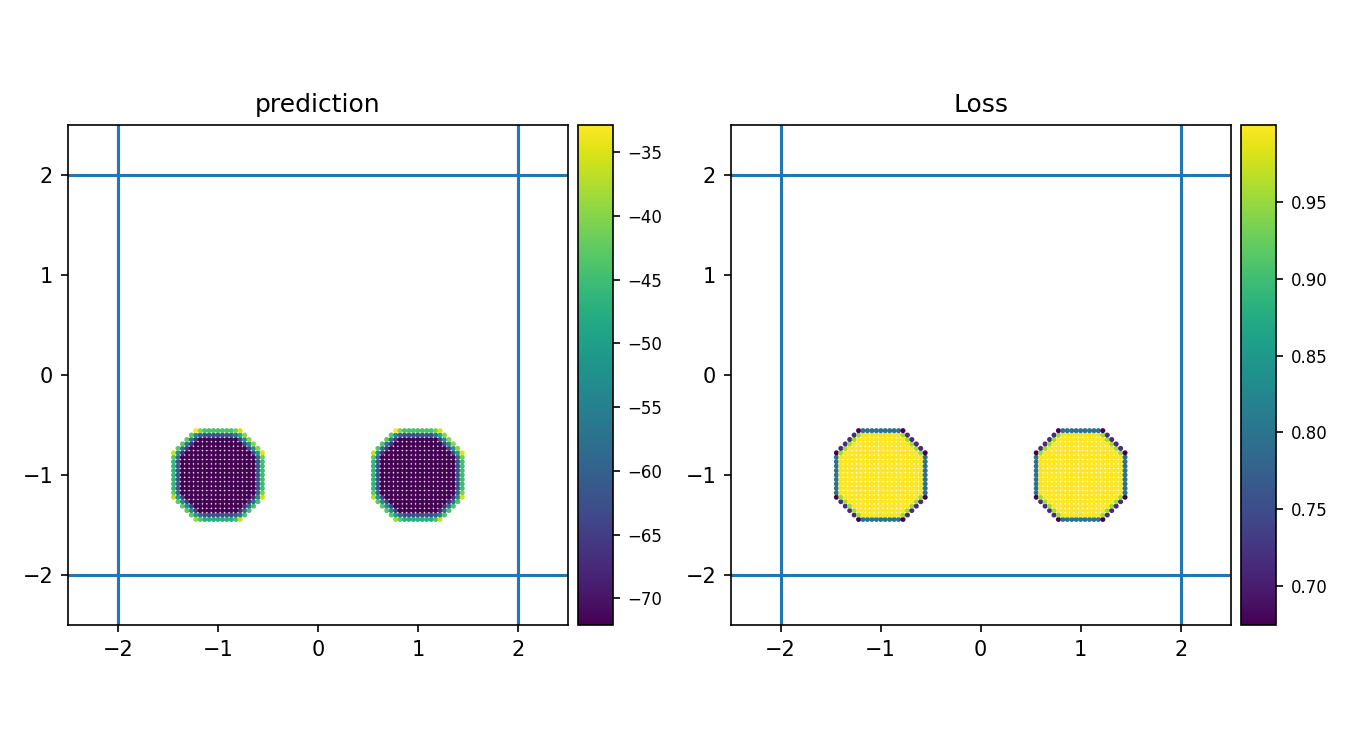

In [144]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

debugPrint(modelOutput.shape)

positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = (gt[:,-1:] - modelOutput) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = modelOutput.detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = (gt[:,-1:] - modelOutput) ** 2
v = (gt[:,-1:] )

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


<IPython.core.display.Javascript object>


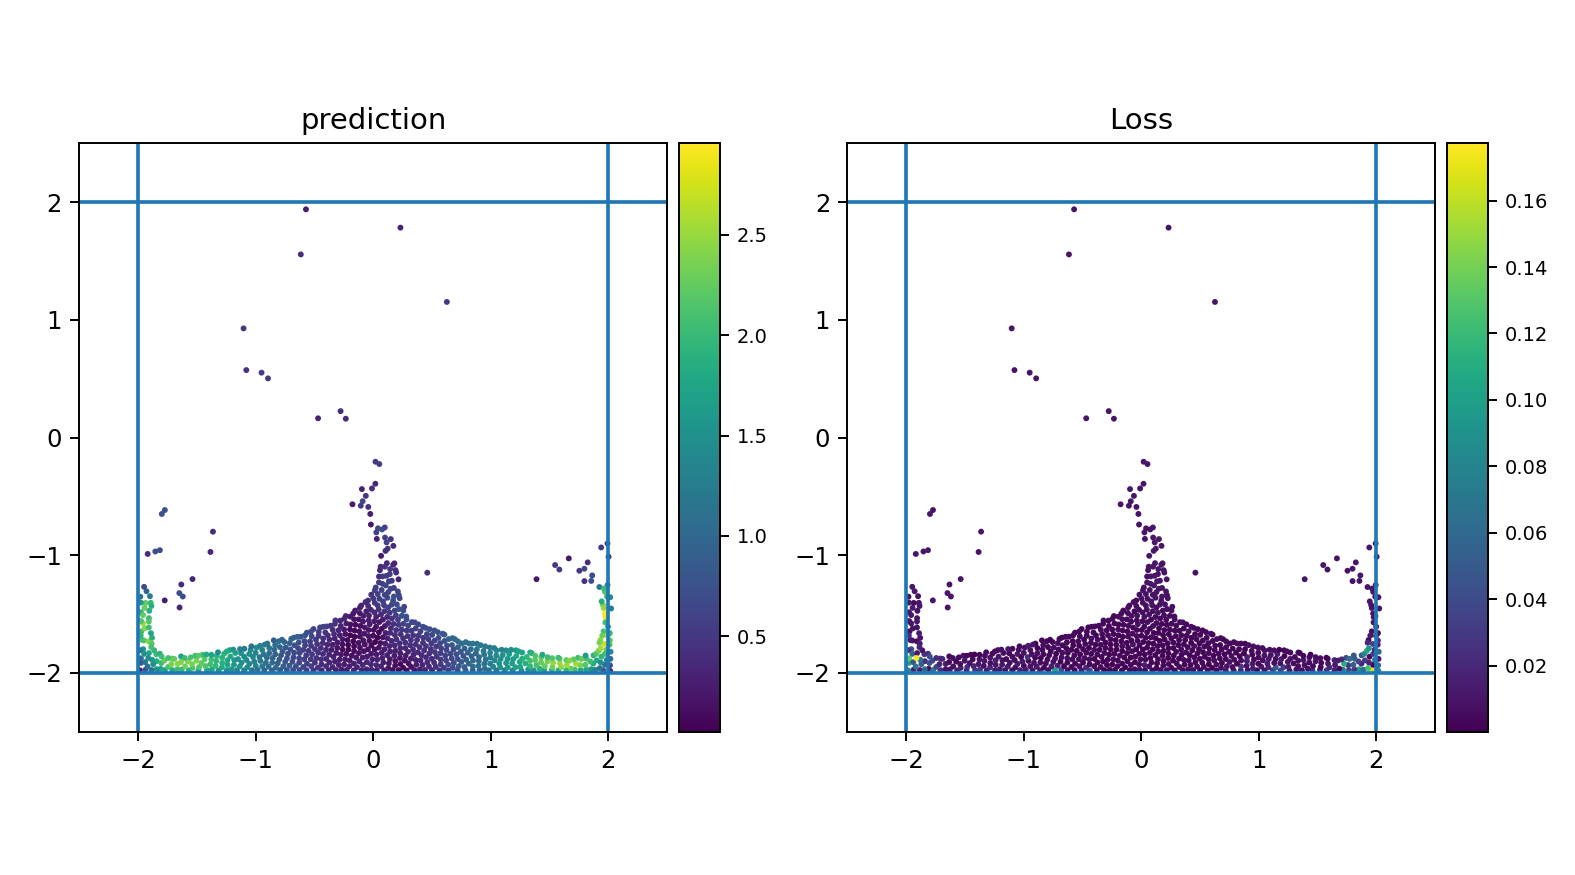

In [50]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)


positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt[:,2:] - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(gt[:,2:] - predictedVelocity,axis=1).detach().cpu().numpy()

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v, s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


In [141]:


# predictedPosition = inputData['fluidPosition'].to(device)
# predictedVelocity = inputData['fluidVelocity'].to(device)

for i in tqdm(range(128)):
#     debugPrint(i)
    fluidFeatures[:,1:3] = predictedVelocity
    
    modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

    newPosition = predictedPosition + attributes['dt'] * predictedVelocity
    newVelocity = predictedVelocity +  modelOutput

    data = (torch.linalg.norm(modelOutput, dim = 1) ** 2).detach().cpu().numpy()
    data = (torch.linalg.norm(newVelocity, dim = 1) ** 2).detach().cpu().numpy()
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    predSC.set_offsets(newPosition.detach().cpu().numpy())
    predSC.set_array(data)

    attributes, inputData, groundTruthData = loadFrame(fileName,frameIndex + 1)
    data = (torch.linalg.norm(inputData['fluidPosition'].to(device) - newPosition, dim = 1) ** 2).detach().cpu().numpy()
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    GTsc.set_offsets(inputData['fluidPosition'].detach().cpu().numpy())
    GTsc.set_array(data)

    predictedPosition = newPosition
    predictedVelocity = newVelocity
    fig.canvas.draw()
    fig.canvas.flush_events()

    frameIndex = frameIndex + 1
# for i in range(8):
#     modelOutput = model(predictedPosition, predictedVelocity, predictedPosition, attrs['support'], None, None)

#     predictedPosition = inputData['fluidPosition'] + attrs['dt'] * inputData['fluidVelocity']
#     predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput

#     gt = gtData[0].type(torch.float32).to(device)
    
    
    

  0%|          | 0/128 [00:00<?, ?it/s]